# Notebook for Getting Started with Real-World Robots with `lerobot`

```{note}
This notebook content is derived from lerobot repo's example note "[7_get_started_with_real_robot.md](https://github.com/huggingface/lerobot/blob/main/examples/7_get_started_with_real_robot.md)".

It is formated in Jupyter notebook style, so that one can just follow this notebook on Jupyter Lab server (that runs on lerobot container on Jetson).

Please note that this is not the full copy for the original note, but just the essense and important part that involves in some Python code executions are extracted.
For the full documentation, please refer to the original document ("[7_get_started_with_real_robot.md](https://github.com/huggingface/lerobot/blob/main/examples/7_get_started_with_real_robot.md)").
```

```{contents} Table of Contents
:depth: 3
```

## 1. Order and Assemble your Koch v1.1

Refer to [the section on the original document](https://github.com/huggingface/lerobot/blob/main/examples/7_get_started_with_real_robot.md#1-order-and-assemble-your-koch-v11).

## 2. Configure motors, calibrate arms, teleoperate your Koch v1.1

Skip the section of the original document, where it talks about the installation of dependencies, connecting 5V and 12V powers and connectiong USB cables.

Instead, skip to "Instatntiate the DynamixelMotorBus" section of this notebook.

### a. Control your motors with DynamixelMotorsBus

#### Instantiate the DynamixelMotorsBus

Skip this section of the original document, as it involves with disconnecting the USB cable and plugging that back in, which is not well suported with Docker (`jetson-containers`).

Instead, follow the "Before starting the container : Set udev rule" section of docs.md.

In case you missed it, below cells store the copy of the instruction.

#### Before starting the container : Set udev rule

On Jetson host side, we set an udev rule so that arms always get assigned the same device name as following.

- `/dev/ttyACM_kochleader`   : Leader arm
- `/dev/ttyACM_kochfollower` : Follower arm

First only connect the leader arm to Jetson and record the serial ID by running the following:

```bash
ll /dev/serial/by-id/
```

The output should look like this.

```bash
lrwxrwxrwx 1 root root 13 Sep 24 13:07 usb-ROBOTIS_OpenRB-150_BA98C8C350304A46462E3120FF121B06-if00 -> ../../ttyACM1
```

Then edit the first line of `./data/lerobot/99-usb-serial.rules` like the following.

```
SUBSYSTEM=="tty", ATTRS{idVendor}=="2f5d", ATTRS{idProduct}=="2202", ATTRS{serial}=="BA98C8C350304A46462E3120FF121B06", SYMLINK+="ttyACM_kochleader"
SUBSYSTEM=="tty", ATTRS{idVendor}=="2f5d", ATTRS{idProduct}=="2202", ATTRS{serial}=="00000000000000000000000000000000", SYMLINK+="ttyACM_kochfollower"
```

Now disconnect the leader arm, and then only connect the follower arm to Jetson.

Repeat the same steps to record the serial to edit the second line of `99-usb-serial.rules` file.

```bash
$ ll /dev/serial/by-id/
lrwxrwxrwx 1 root root 13 Sep 24 13:07 usb-ROBOTIS_OpenRB-150_483F88DC50304A46462E3120FF0C081A-if00 -> ../../ttyACM0
$ vi ./data/lerobot/99-usb-serial.rules
```

You should have `./data/lerobot/99-usb-serial.rules` now looking like this:

```
SUBSYSTEM=="tty", ATTRS{idVendor}=="2f5d", ATTRS{idProduct}=="2202", ATTRS{serial}=="BA98C8C350304A46462E3120FF121B06", SYMLINK+="ttyACM_kochleader"
SUBSYSTEM=="tty", ATTRS{idVendor}=="2f5d", ATTRS{idProduct}=="2202", ATTRS{serial}=="483F88DC50304A46462E3120FF0C081A", SYMLINK+="ttyACM_kochfollower"
```

Finally copy this under `/etc/udev/rules.d/`, and restart Jetson.

```
sudo cp ./data/lerobot/99-usb-serial.rules /etc/udev/rules.d/
sudo reboot
```

After reboot, check if we now have achieved the desired fixed simlinks names for the arms.

```bash
ls -l /dev/ttyACM*
```

You should get something like this:

```bash
crw-rw---- 1 root dialout 166, 0 Sep 24 17:20 /dev/ttyACM0
crw-rw---- 1 root dialout 166, 1 Sep 24 16:13 /dev/ttyACM1
lrwxrwxrwx 1 root root         7 Sep 24 17:20 /dev/ttyACM_kochfollower -> ttyACM0
lrwxrwxrwx 1 root root         7 Sep 24 16:13 /dev/ttyACM_kochleader -> ttyACM1
```

#### Start the container

```bash
./run.sh \
  -v ${PWD}/data/lerobot/.cache/calibration/koch:/opt/lerobot/.cache/calibration/koch \
  -v ${PWD}/data/lerobot/lerobot/configs/robot/koch.yaml:/opt/lerobot/lerobot/configs/robot/koch.yaml \
  -v ${PWD}/data/lerobot/notebooks/:/opt/lerobot/notebooks \
  -e JUPYTER_ROOT=/opt/lerobot/ \
  $(./autotag lerobot)
```

#### Listing and Configuring Motors

For configuring motors, it is highly recommended to take the **Dynamixel Wizard 2.0** route on your PC (not on Jetson).

You can perform this with GUI on your daily PC, be that Mac, Windows or Linux.<br>
Below image shows what you should get at the end of following the path of updating firmware and assinging IDs to each motors on Dynamixel Wizard 2.0 on Windows. 

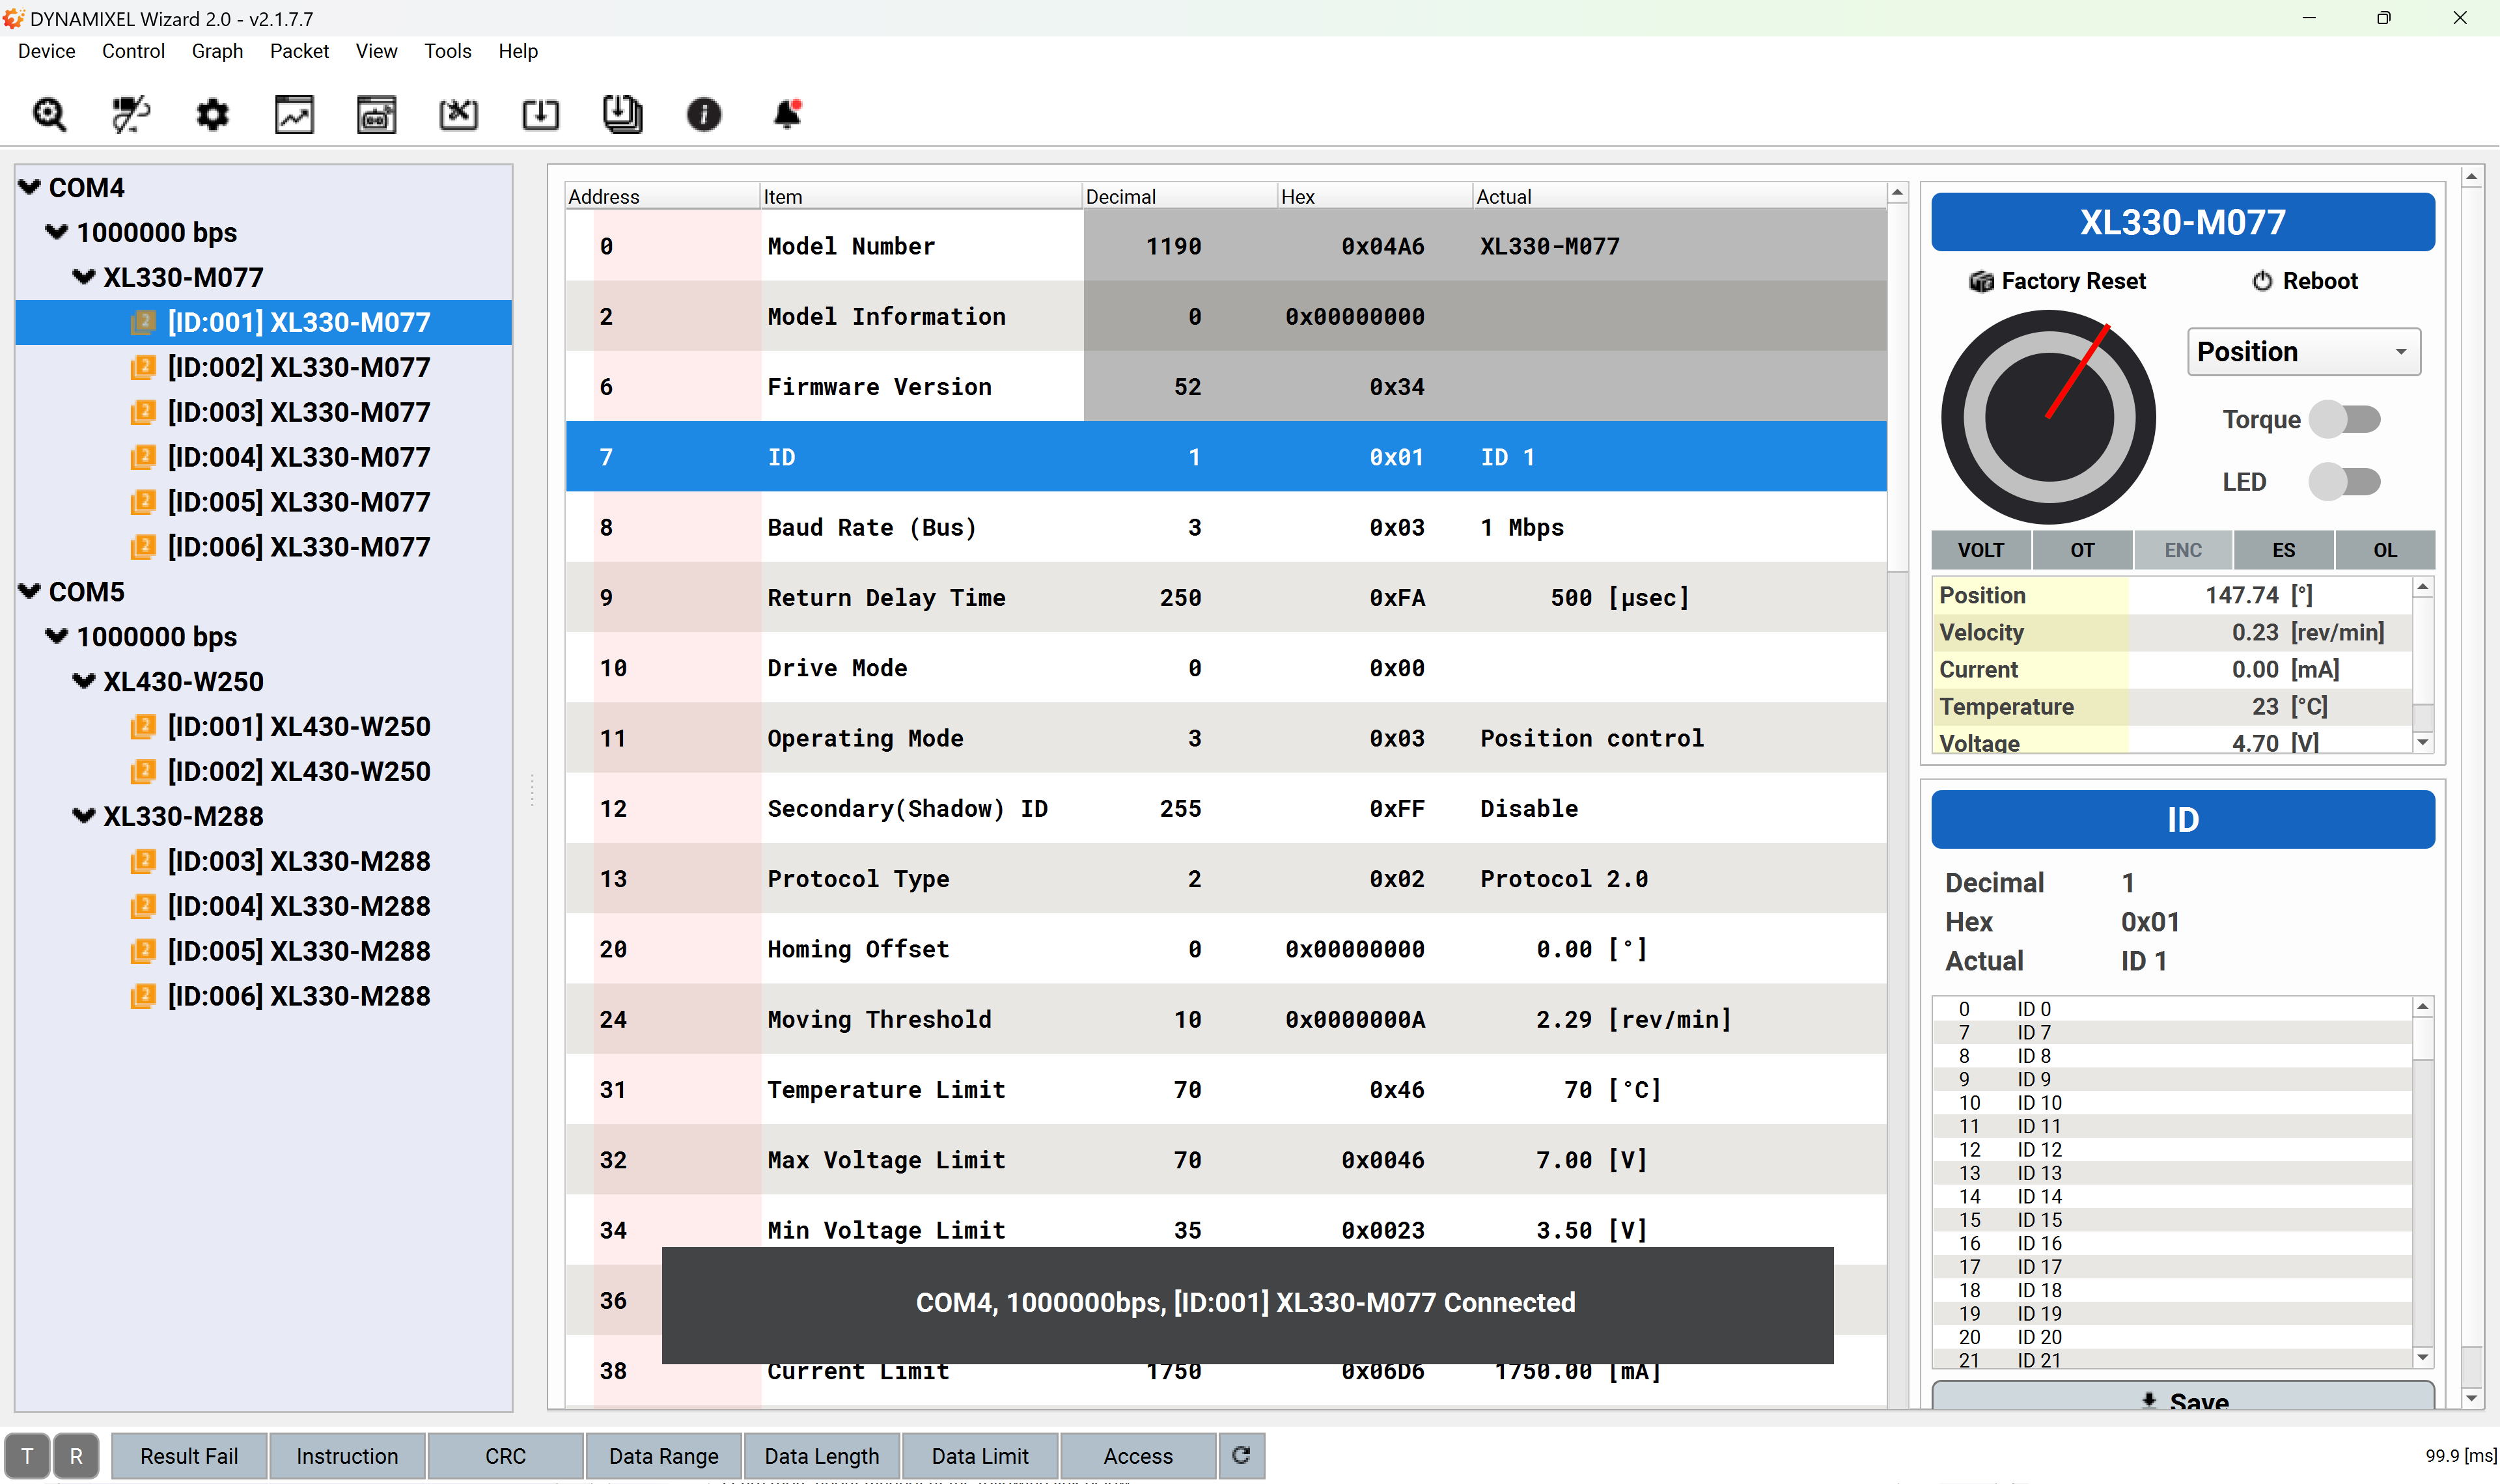

Once everything is set up, run the following cells (inside the lerobot container running on Jetson) to check if everything is set up correctly.

In [1]:
!ls /dev/ttyACM*

/dev/ttyACM0  /dev/ttyACM1  /dev/ttyACM_kochfollower  /dev/ttyACM_kochleader


In [2]:
from lerobot.common.robot_devices.motors.dynamixel import DynamixelMotorsBus

leader_port = "/dev/ttyACM_kochleader"
follower_port = "/dev/ttyACM_kochfollower"

leader_arm = DynamixelMotorsBus(
    port=leader_port,
    motors={
        # name: (index, model)
        "shoulder_pan": (1, "xl330-m077"),
        "shoulder_lift": (2, "xl330-m077"),
        "elbow_flex": (3, "xl330-m077"),
        "wrist_flex": (4, "xl330-m077"),
        "wrist_roll": (5, "xl330-m077"),
        "gripper": (6, "xl330-m077"),
    },
)

follower_arm = DynamixelMotorsBus(
    port=follower_port,
    motors={
        # name: (index, model)
        "shoulder_pan": (1, "xl430-w250"),
        "shoulder_lift": (2, "xl430-w250"),
        "elbow_flex": (3, "xl330-m288"),
        "wrist_flex": (4, "xl330-m288"),
        "wrist_roll": (5, "xl330-m288"),
        "gripper": (6, "xl330-m288"),
    },
)

In [3]:
leader_arm.connect()

In [4]:
follower_arm.connect()

#### Read and Write with DynamixelMotorsBus

To get familiar with how `DynamixelMotorsBus` communicates with the motors, you can start by reading data from them. 

Expected out:

```
array([2054,  523, 3071, 1831, 3049, 2441], dtype=int32)
array([2003, 1601,   56, 2152, 3101, 2283], dtype=int32)
```

In [ ]:
leader_pos = leader_arm.read("Present_Position")
follower_pos = follower_arm.read("Present_Position")
print(leader_pos)
print(follower_pos)

Torque control.

Run the following, and you will see the follower arm be locked in its current position.

Do not attempt to manually move the arm while torque is enabled, as this could damage the motors.

In [ ]:
from lerobot.common.robot_devices.motors.dynamixel import TorqueMode

follower_arm.write("Torque_Enable", TorqueMode.ENABLED.value)

Now, to get more familiar with reading and writing, let's move the arm programmatically by running the following example code:

In [ ]:
# Get the current position
position = follower_arm.read("Present_Position")

# Update first motor (shoulder_pan) position by +10 steps
position[0] += 10
follower_arm.write("Goal_Position", position)

# Update all motors position by -30 steps
position -= 30
follower_arm.write("Goal_Position", position)

# Update gripper by +30 steps
position[-1] += 30
follower_arm.write("Goal_Position", position[-1], "gripper")

When you're done playing, you can try to disable the torque, but make sure you hold your robot so that it doesn't fall:



In [ ]:
follower_arm.write("Torque_Enable", TorqueMode.DISABLED.value)

Finally, disconnect the arms:



In [5]:
leader_arm.disconnect()
follower_arm.disconnect()

Alternatively, you can unplug the power cord, which will automatically disable torque and disconnect the motors.

⚠️ Warning: These motors tend to overheat, especially under torque or if left plugged in for too long. Unplug after use.

### b. Teleoperate your Koch v1.1 with ManipulatorRobot

#### Instantiate the ManipulatorRobot

Before you can teleoperate your robot, you need to instantiate the  [`ManipulatorRobot`](../lerobot/common/robot_devices/robots/manipulator.py) using the previously defined `leader_arm` and `follower_arm`.

For the Koch v1.1 robot, we only have one leader, so we refer to it as `"main"` and define it as `leader_arms={"main": leader_arm}`. We do the same for the follower arm. For other robots (like the Aloha), which may have two pairs of leader and follower arms, you would define them like this: `leader_arms={"left": left_leader_arm, "right": right_leader_arm},`. Same thing for the follower arms.

You also need to provide a path to a calibration directory, such as  `calibration_dir=".cache/calibration/koch"`. More on this in the next section.


Run the following code to instantiate your manipulator robot:

In [6]:
from lerobot.common.robot_devices.robots.manipulator import ManipulatorRobot

robot = ManipulatorRobot(
    robot_type="koch",
    leader_arms={"main": leader_arm},
    follower_arms={"main": follower_arm},
    calibration_dir="/opt/lerobot/.cache/calibration/koch",
)

The `robot_type="koch"` is used to set the associated settings and calibration process. For instance, we activate the torque of the gripper of the leader Koch v1.1 arm and position it at a 40 degree angle to use it as a trigger.

For the [Aloha bimanual robot](https://aloha-2.github.io), we would use `robot_type="aloha"` to set different settings such as a secondary ID for shadow joints (shoulder, elbow). Specific to Aloha, LeRobot comes with default calibration files stored in in `.cache/calibration/aloha_default`. Assuming the motors have been properly assembled, no manual calibration step is expected. If you need to run manual calibration, simply update `calibration_dir` to `.cache/calibration/aloha`.

#### Calibrate and Connect the ManipulatorRobot

Next, you'll need to calibrate your Koch robot to ensure that the leader and follower arms have the same position values when they are in the same physical position. This calibration is essential because it allows a neural network trained on one Koch robot to work on another.

When you connect your robot for the first time, the [`ManipulatorRobot`](../lerobot/common/robot_devices/robots/manipulator.py) will detect if the calibration file is missing and trigger the calibration procedure. During this process, you will be guided to move each arm to three different positions.

Here are the positions you'll move the follower arm to:

| 1. Zero position | 2. Rotated position | 3. Rest position |
|---|---|---|
| <img src="https://github.com/huggingface/lerobot/raw/main/media/koch/follower_zero.webp?raw=true" alt="Koch v1.1 follower arm zero position" title="Koch v1.1 follower arm zero position" style="width:100%;"> | <img src="https://github.com/huggingface/lerobot/raw/main/media/koch/follower_rotated.webp?raw=true" alt="Koch v1.1 follower arm rotated position" title="Koch v1.1 follower arm rotated position" style="width:100%;"> | <img src="https://github.com/huggingface/lerobot/raw/main/media/koch/follower_rest.webp?raw=true" alt="Koch v1.1 follower arm rest position" title="Koch v1.1 follower arm rest position" style="width:100%;"> |

And here are the corresponding positions for the leader arm:

| 1. Zero position | 2. Rotated position | 3. Rest position |
|---|---|---|
| <img src="https://github.com/huggingface/lerobot/raw/main/media/koch/leader_zero.webp?raw=true" alt="Koch v1.1 leader arm zero position" title="Koch v1.1 leader arm zero position" style="width:100%;"> | <img src="https://github.com/huggingface/lerobot/raw/main/media/koch/leader_rotated.webp?raw=true" alt="Koch v1.1 leader arm rotated position" title="Koch v1.1 leader arm rotated position" style="width:100%;"> | <img src="https://github.com/huggingface/lerobot/raw/main/media/koch/leader_rest.webp?raw=true" alt="Koch v1.1 leader arm rest position" title="Koch v1.1 leader arm rest position" style="width:100%;">

You can watch a video tutorial of the calibration procedure for more details.

During calibration, we count the number of full 360-degree rotations your motors have made since they were first used. That's why we ask yo to move to this arbitrary "zero" position. We don't actually "set" the zero position, so you don't need to be accurate. After calculating these "offsets" to shift the motor values around 0, we need to assess the rotation direction of each motor, which might differ. That's why we ask you to rotate all motors to roughly 90 degrees, to mesure if the values changed negatively or positively.

Finally, the rest position ensures that the follower and leader arms are roughly aligned after calibration, preventing sudden movements that could damage the motors when starting teleoperation.

Importantly, once calibrated, all Koch robots will move to the same positions (e.g. zero and rotated position) when commanded.

Run the following code to calibrate and connect your robot:

The output will look like this:
```
Connecting main follower arm
Connecting main leader arm

Missing calibration file '.cache/calibration/koch/main_follower.json'
Running calibration of koch main follower...
Move arm to zero position
[...]
Move arm to rotated position
[...]
Move arm to rest position
[...]
Calibration is done! Saving calibration file '.cache/calibration/koch/main_follower.json'

Missing calibration file '.cache/calibration/koch/main_leader.json'
Running calibration of koch main leader...
Move arm to zero position
[...]
Move arm to rotated position
[...]
Move arm to rest position
[...]
Calibration is done! Saving calibration file '.cache/calibration/koch/main_leader.json'
```



In [7]:
robot.connect()

Connecting main follower arm.
Connecting main leader arm.
Missing calibration file '/opt/lerobot/.cache/calibration/koch/main_follower.json'

Running calibration of koch main follower...

Move arm to zero position
See: https://raw.githubusercontent.com/huggingface/lerobot/main/media/koch/follower_zero.webp


Press Enter to continue... 



Move arm to rotated target position
See: https://raw.githubusercontent.com/huggingface/lerobot/main/media/koch/follower_rotated.webp


Press Enter to continue... 



Move arm to rest position
See: https://raw.githubusercontent.com/huggingface/lerobot/main/media/koch/follower_rest.webp


Press Enter to continue... 



Calibration is done! Saving calibration file '/opt/lerobot/.cache/calibration/koch/main_follower.json'
Missing calibration file '/opt/lerobot/.cache/calibration/koch/main_leader.json'

Running calibration of koch main leader...

Move arm to zero position
See: https://raw.githubusercontent.com/huggingface/lerobot/main/media/koch/leader_zero.webp


Press Enter to continue... 



Move arm to rotated target position
See: https://raw.githubusercontent.com/huggingface/lerobot/main/media/koch/leader_rotated.webp


Press Enter to continue... 



Move arm to rest position
See: https://raw.githubusercontent.com/huggingface/lerobot/main/media/koch/leader_rest.webp


Press Enter to continue... 



Calibration is done! Saving calibration file '/opt/lerobot/.cache/calibration/koch/main_leader.json'
Activating torque on main follower arm.


#### Verifying Calibration

Once calibration is complete, you can check the positions of the leader and follower arms to ensure they match. If the calibration was successful, the positions should be very similar.


Run this code to get the positions in degrees:

Example output:
```
array([-0.43945312, 133.94531, 179.82422, -18.984375, -1.9335938, 34.541016], dtype=float32)
array([-0.58723712, 131.72314, 174.98743, -16.872612, 0.786213, 35.271973], dtype=float32)
```

In [8]:
leader_pos = robot.leader_arms["main"].read("Present_Position")
follower_pos = robot.follower_arms["main"].read("Present_Position")

print(leader_pos)
print(follower_pos)

[ -5.2734375 133.0664    179.29688   -30.761719    4.482422   43.154297 ]
[  1.0546875 115.83984   176.74805   -20.302734    0.6152344  50.097656 ]


These values are in degrees, which makes them easier to interpret and debug. The zero position used during calibration should roughly correspond to 0 degrees for each motor, and the rotated position should roughly correspond to 90 degrees for each motor.


#### Teleoperate your Koch v1.1

You can easily teleoperate your robot by reading the positions from the leader arm and sending them as goal positions to the follower arm.

To teleoperate your robot for 30 seconds at a frequency of approximately 200Hz, run the following code:


In [13]:
import tqdm
seconds = 30
frequency = 200
for _ in tqdm.tqdm(range(seconds*frequency)):
    leader_pos = robot.leader_arms["main"].read("Present_Position")
    robot.follower_arms["main"].write("Goal_Position", leader_pos)

100%|██████████| 6000/6000 [00:30<00:00, 197.02it/s]


#### Using `teleop_step` for Teleoperation

Alternatively, you can teleoperate the robot using the `teleop_step` method from [`ManipulatorRobot`](../lerobot/common/robot_devices/robots/manipulator.py).

Run this code to teleoperate:


In [14]:
for _ in tqdm.tqdm(range(seconds*frequency)):
    robot.teleop_step()

100%|██████████| 6000/6000 [00:30<00:00, 194.90it/s]


#### Recording data during Teleoperation

Teleoperation is particularly useful for recording data. You can use the `teleop_step(record_data=True)` to returns both the follower arm's position as `"observation.state"` and the leader arm's position as `"action"`. This function also converts the numpy arrays into PyTorch tensors. If you're working with a robot that has two leader and two follower arms (like the Aloha), the positions are concatenated.


Run the following code to see how slowly moving the leader arm affects the observation and action:

Expected output:
```
array([7.8223, 131.1328, 165.5859, -23.4668, -0.9668, 32.4316], dtype=float32)
{'observation.state': tensor([7.8223, 131.1328, 165.5859, -23.4668, -0.9668, 32.4316])}
array([3.4277, 134.1211, 179.8242, -18.5449, -1.5820, 34.7168], dtype=float32)
{'action': tensor([3.4277, 134.1211, 179.8242, -18.5449, -1.5820, 34.7168])}
```

In [17]:
leader_pos = robot.leader_arms["main"].read("Present_Position")
follower_pos = robot.follower_arms["main"].read("Present_Position")
observation, action = robot.teleop_step(record_data=True)

print(follower_pos)
print(observation)
print(leader_pos)
print(action)

[ -0.9667969  49.746094   38.23242    73.56445   -91.93359    19.59961  ]
{'observation.state': tensor([ -0.9668,  49.7461,  38.2324,  73.5645, -92.0215,  19.5996])}
[ -1.4941406  63.632812   75.84961    74.00391   -92.109375   19.248047 ]
{'action': tensor([ -1.4941,  63.6328,  75.8496,  74.0039, -92.1094,  19.2480])}


#### Asynchronous Frame Recording

Additionally, `teleop_step` can asynchronously record frames from multiple cameras and include them in the observation dictionary as `"observation.images.CAMERA_NAME"`. This feature will be covered in more detail in the next section.


#### Disconnecting the Robot

When you're finished, make sure to disconnect your robot by running:

In [18]:
robot.disconnect()

Alternatively, you can unplug the power cord, which will also disable torque.

⚠️ Warning: These motors tend to overheat, especially under torque or if left plugged in for too long. Unplug after use.

### c. Add your cameras with OpenCVCamera

#### (Optional) Use your phone as camera on Linux

Skip this section for Jetson.

#### (Optional) Use your iPhone as a camera on MacOS

Skip this section for Jetson.

#### Instantiate an OpenCVCamera

The [`OpenCVCamera`](../lerobot/common/robot_devices/cameras/opencv.py) class allows you to efficiently record frames from most cameras using the [`opencv2`](https://docs.opencv.org) library.  For more details on compatibility, see [Video I/O with OpenCV Overview](https://docs.opencv.org/4.x/d0/da7/videoio_overview.html).

To instantiate an [`OpenCVCamera`](../lerobot/common/robot_devices/cameras/opencv.py), you need a camera index (e.g. `OpenCVCamera(camera_index=0)`). When you only have one camera like a webcam of a laptop, the camera index is usually `0` but it might differ, and the camera index might change if you reboot your computer or re-plug your camera. This behavior depends on your operating system.



To find the camera indices, run the following utility script, which will save a few frames from each detected camera:

In [3]:
!python3 /opt/lerobot/lerobot/common/robot_devices/cameras/opencv.py \
    --images-dir /opt/lerobot/outputs/images_from_opencv_cameras

Linux detected. Finding available camera indices through scanning '/dev/video*' ports
sh: 1: lsmod: not found
sh: 1: modprobe: not found
[ WARN:0@3.866] global cap_gstreamer.cpp:1173 isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ WARN:0@3.866] global cap_v4l.cpp:999 open VIDEOIO(V4L2:/dev/video1): can't open camera by index
[ERROR:0@3.870] global obsensor_uvc_stream_channel.cpp:158 getStreamChannelGroup Camera index out of range
[ WARN:0@3.870] global cap_gstreamer.cpp:1173 isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
Camera found at index 0
Connecting cameras
[ WARN:0@3.909] global cap_gstreamer.cpp:1173 isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ WARN:0@3.909] global cap.cpp:164 open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.10.0) /opt/opencv-python/opencv/modules/videoio/src/cap_gstreamer.cpp:1468: error: (-215:Assertion failed) uridecodebi

The output will look something like this if you have two cameras connected:
```
Mac or Windows detected. Finding available camera indices through scanning all indices from 0 to 60
[...]
Camera found at index 0
Camera found at index 1
[...]
Connecting cameras
OpenCVCamera(0, fps=30.0, width=1920.0, height=1080.0, color_mode=rgb)
OpenCVCamera(1, fps=24.0, width=1920.0, height=1080.0, color_mode=rgb)
Saving images to outputs/images_from_opencv_cameras
Frame: 0000	Latency (ms): 39.52
[...]
Frame: 0046	Latency (ms): 40.07
Images have been saved to outputs/images_from_opencv_cameras
```

Check the saved images in `outputs/images_from_opencv_cameras` to identify which camera index corresponds to which physical camera (e.g. `0` for `camera_00` or `1` for `camera_01`):
```
camera_00_frame_000000.png
[...]
camera_00_frame_000047.png
camera_01_frame_000000.png
[...]
camera_01_frame_000047.png
```

Note: Some cameras may take a few seconds to warm up, and the first frame might be black or green.

Finally, run this code to instantiate and connect your camera:


In [15]:
from lerobot.common.robot_devices.cameras.opencv import OpenCVCamera

camera = OpenCVCamera(camera_index=0)
camera.connect()
color_image = camera.read()

print(color_image.shape)
print(color_image.dtype)

[ WARN:0@539.396] global cap_gstreamer.cpp:1173 isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ WARN:0@539.396] global cap.cpp:164 open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.10.0) /opt/opencv-python/opencv/modules/videoio/src/cap_gstreamer.cpp:1468: error: (-215:Assertion failed) uridecodebin in function 'open'


[ WARN:0@539.425] global cap_gstreamer.cpp:1173 isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ WARN:0@539.425] global cap.cpp:164 open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.10.0) /opt/opencv-python/opencv/modules/videoio/src/cap_gstreamer.cpp:1468: error: (-215:Assertion failed) uridecodebin in function 'open'




(480, 640, 3)
uint8


[ WARN:0@809.362] global cap_gstreamer.cpp:1173 isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ WARN:0@809.362] global cap.cpp:164 open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.10.0) /opt/opencv-python/opencv/modules/videoio/src/cap_gstreamer.cpp:1468: error: (-215:Assertion failed) uridecodebin in function 'open'


[ WARN:0@809.391] global cap_gstreamer.cpp:1173 isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ WARN:0@809.391] global cap.cpp:164 open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.10.0) /opt/opencv-python/opencv/modules/videoio/src/cap_gstreamer.cpp:1468: error: (-215:Assertion failed) uridecodebin in function 'open'




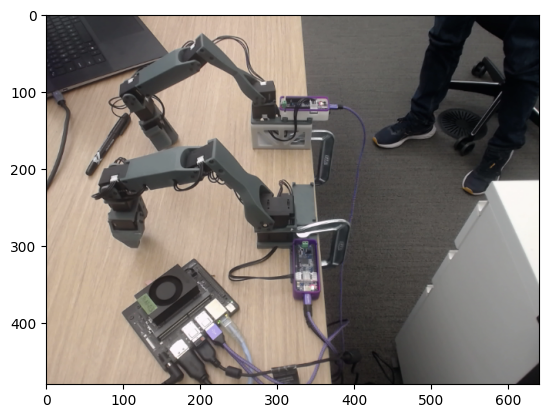

In [36]:
import cv2
from matplotlib import pyplot as plt
from lerobot.common.robot_devices.cameras.opencv import OpenCVCamera

camera = OpenCVCamera(camera_index=0)
camera.connect()
color_image = camera.read()

plt.imshow(color_image)
plt.show()

When you're done using the camera, disconnect it by running:

In [37]:
camera.disconnect()

#### Instantiate your robot with cameras



### d. Use koch.yaml and our teleoperate function


## 3. Record your Dataset and Visualize it

### a. Use `koch.yaml` and the `record` function

### b. Advices for recording dataset

### c. Visualize all episodes

## 4. Train a policy on your data

### a. Use the `train` script

### b. (Optional) Upload policy checkpoints to the hub

## 5. Evaluate your policy

### a. Use `koch.yaml` and our `record` function

### b. Visualize evaluation afterwards

## 6. Next step